In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/data/GAN/patches-normal.zip > /dev/null

replace patches-normal/MyRecord2022-03-23T1224371360_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
path = glob.glob("./patches-normal/*.jpg")

# images =[]
# for file in tqdm(path):
#     img = plt.imread(file)
#     # img = cv2.resize(img, (64,64))
#     # plt.imshow(img)
#     img = img / 255. * 2. - 1.
#     images.append(img)
# X_train = np.asarray(images)

np.random.seed(42)
tf.random.set_seed(42)
batch_size = 32
codings_size = 100

def get_image():
   for file in path:
     img = plt.imread(file)
     img = img / 255. * 2. - 1.
     yield img # Your supposed to yield in a loop

dataset = tf.data.Dataset.from_generator(get_image, output_types=(tf.float32))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

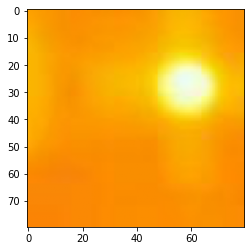

In [ ]:
plt.imshow(np.squeeze((X_train[0] + 1.) / 2.))

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image = (image + 1.) / 2.
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1000):
    generator, discriminator = gan.layers
    for i, epoch in enumerate(range(n_epochs)):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for j,  X_batch in enumerate(tqdm(dataset)):
            X_batch = tf.cast(X_batch, tf.float32)
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        if i % 20 == 0:
          gan.save("./drive/MyDrive/models/GAN/6_gan_{}.hdf5".format(i))
          plot_multiple_images(generated_images, 8)
          plt.show()

In [ ]:
# np.random.seed(42)
# tf.random.set_seed(42)
# batch_size = 32
# codings_size = 100
# dataset = tf.data.Dataset.from_tensor_slices(X_train)
# dataset = dataset.shuffle(1000)
# dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

InternalError: ignored

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Dense(5 * 5 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([5, 5, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),    
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[80, 80, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6400)              646400    
                                                                 
 reshape (Reshape)           (None, 5, 5, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])

Epoch 1/1000


2053it [02:20, 14.62it/s]
  0%|          | 1/65718 [04:45<5203:27:43, 285.05s/it]


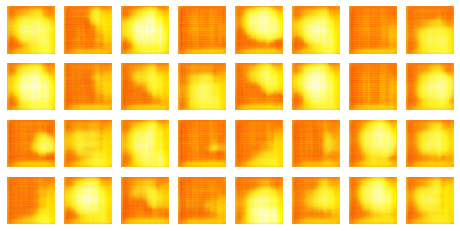

Epoch 2/1000


2053it [02:19, 14.70it/s]


Epoch 3/1000


2053it [02:19, 14.77it/s]


Epoch 4/1000


2053it [02:19, 14.77it/s]


Epoch 5/1000


2053it [02:17, 14.88it/s]


Epoch 6/1000


2053it [02:18, 14.84it/s]


Epoch 7/1000


2053it [02:18, 14.81it/s]


Epoch 8/1000


2053it [02:18, 14.81it/s]


Epoch 9/1000


2053it [02:18, 14.78it/s]


Epoch 10/1000


2053it [02:17, 14.93it/s]


Epoch 11/1000


2053it [02:17, 14.88it/s]


Epoch 12/1000


2053it [02:17, 14.92it/s]


Epoch 13/1000


2053it [02:18, 14.82it/s]


Epoch 14/1000


2053it [02:17, 14.91it/s]


Epoch 15/1000


2053it [02:17, 14.90it/s]


Epoch 16/1000


2053it [02:18, 14.81it/s]


Epoch 17/1000


2053it [02:18, 14.87it/s]


Epoch 18/1000


2053it [02:18, 14.87it/s]


Epoch 19/1000


2053it [02:17, 14.92it/s]


Epoch 20/1000


2053it [02:20, 14.62it/s]


Epoch 21/1000


2053it [02:21, 14.48it/s]


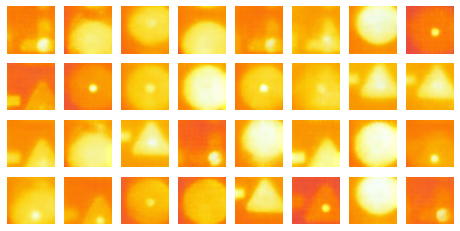

Epoch 22/1000


2053it [02:22, 14.41it/s]


Epoch 23/1000


2053it [02:20, 14.57it/s]


Epoch 24/1000


2053it [02:21, 14.56it/s]


Epoch 25/1000


2053it [02:21, 14.51it/s]


Epoch 26/1000


2053it [02:21, 14.55it/s]


Epoch 27/1000


2053it [02:21, 14.52it/s]


Epoch 28/1000


2053it [02:21, 14.56it/s]


Epoch 29/1000


2053it [02:21, 14.53it/s]


Epoch 30/1000


2053it [02:20, 14.63it/s]


Epoch 31/1000


2053it [02:20, 14.58it/s]


Epoch 32/1000


2053it [02:17, 14.98it/s]


Epoch 33/1000


2053it [02:17, 14.97it/s]


Epoch 34/1000


2053it [02:15, 15.10it/s]


Epoch 35/1000


2053it [02:16, 15.08it/s]


Epoch 36/1000


2053it [02:16, 15.03it/s]


Epoch 37/1000


2053it [02:17, 14.96it/s]


Epoch 38/1000


2053it [02:17, 14.95it/s]


Epoch 39/1000


2053it [02:15, 15.11it/s]


Epoch 40/1000


2053it [02:16, 15.03it/s]


Epoch 41/1000


2053it [02:16, 15.09it/s]


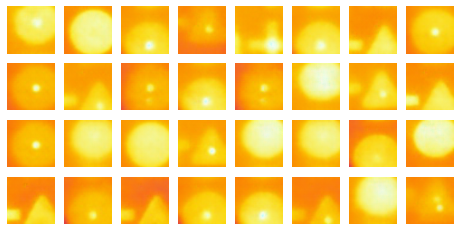

Epoch 42/1000


2053it [02:17, 14.92it/s]


Epoch 43/1000


2053it [02:19, 14.75it/s]


Epoch 44/1000


2053it [02:17, 14.89it/s]


Epoch 45/1000


2053it [02:16, 14.99it/s]


Epoch 46/1000


2053it [02:16, 15.04it/s]


Epoch 47/1000


2053it [02:16, 15.00it/s]


Epoch 48/1000


2053it [02:17, 14.97it/s]


Epoch 49/1000


2053it [02:19, 14.76it/s]


Epoch 50/1000


2053it [02:17, 14.89it/s]


Epoch 51/1000


2053it [02:17, 14.92it/s]


Epoch 52/1000


2053it [02:16, 15.03it/s]


Epoch 53/1000


2053it [02:17, 14.97it/s]


Epoch 54/1000


2053it [02:19, 14.70it/s]


Epoch 55/1000


2053it [02:17, 14.92it/s]


Epoch 56/1000


2053it [02:17, 14.95it/s]


Epoch 57/1000


2053it [02:16, 15.08it/s]


Epoch 58/1000


2053it [02:17, 14.94it/s]


Epoch 59/1000


2053it [02:16, 15.02it/s]


Epoch 60/1000


2053it [02:18, 14.86it/s]


Epoch 61/1000


2053it [02:17, 14.92it/s]


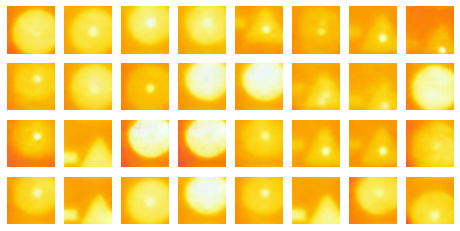

Epoch 62/1000


2053it [02:15, 15.15it/s]


Epoch 63/1000


2053it [02:15, 15.11it/s]


Epoch 64/1000


2053it [02:16, 15.04it/s]


Epoch 65/1000


2053it [02:16, 15.08it/s]


Epoch 66/1000


2053it [02:16, 15.07it/s]


Epoch 67/1000


2053it [02:16, 15.01it/s]


Epoch 68/1000


2053it [02:18, 14.85it/s]


Epoch 69/1000


2053it [02:20, 14.61it/s]


Epoch 70/1000


2053it [02:21, 14.53it/s]


Epoch 71/1000


2053it [02:20, 14.58it/s]


Epoch 72/1000


2053it [02:21, 14.53it/s]


Epoch 73/1000


2053it [02:21, 14.54it/s]


Epoch 74/1000


2053it [02:21, 14.47it/s]


Epoch 75/1000


2053it [02:21, 14.56it/s]


Epoch 76/1000


2053it [02:21, 14.56it/s]


Epoch 77/1000


2053it [02:20, 14.60it/s]


Epoch 78/1000


2053it [02:20, 14.62it/s]


Epoch 79/1000


2053it [02:20, 14.66it/s]


Epoch 80/1000


2053it [02:17, 14.91it/s]


Epoch 81/1000


2053it [02:16, 14.99it/s]


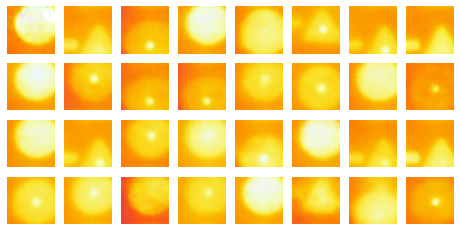

Epoch 82/1000


2053it [02:16, 14.99it/s]


Epoch 83/1000


2053it [02:17, 14.95it/s]


Epoch 84/1000


2053it [02:17, 14.94it/s]


Epoch 85/1000


2053it [02:18, 14.87it/s]


Epoch 86/1000


2053it [02:16, 15.02it/s]


Epoch 87/1000


2053it [02:17, 14.92it/s]


Epoch 88/1000


2053it [02:16, 15.06it/s]


Epoch 89/1000


2053it [02:16, 15.03it/s]


Epoch 90/1000


2053it [02:16, 15.01it/s]


Epoch 91/1000


2053it [02:18, 14.82it/s]


Epoch 92/1000


2053it [02:17, 14.93it/s]


Epoch 93/1000


2053it [02:16, 15.06it/s]


Epoch 94/1000


2053it [02:17, 14.98it/s]


Epoch 95/1000


2053it [02:16, 15.02it/s]


Epoch 96/1000


2053it [02:17, 14.93it/s]


Epoch 97/1000


2053it [02:18, 14.85it/s]


Epoch 98/1000


2053it [02:16, 15.07it/s]


Epoch 99/1000


2053it [02:16, 15.06it/s]


Epoch 100/1000


2053it [02:18, 14.86it/s]


Epoch 101/1000


2053it [02:18, 14.82it/s]


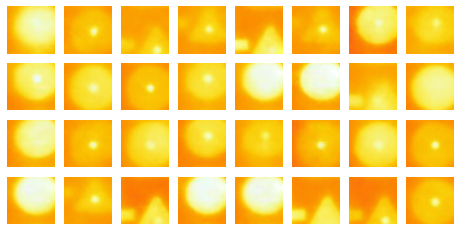

Epoch 102/1000


2053it [02:18, 14.79it/s]


Epoch 103/1000


2053it [02:19, 14.71it/s]


Epoch 104/1000


2053it [02:17, 14.92it/s]


Epoch 105/1000


2053it [02:17, 14.93it/s]


Epoch 106/1000


2053it [02:17, 14.98it/s]


Epoch 107/1000


2053it [02:17, 14.97it/s]


Epoch 108/1000


2053it [02:19, 14.75it/s]


Epoch 109/1000


2053it [02:18, 14.78it/s]


Epoch 110/1000


2053it [02:18, 14.80it/s]


Epoch 111/1000


2053it [02:17, 14.94it/s]


Epoch 112/1000


2053it [02:17, 14.90it/s]


Epoch 113/1000


2053it [02:17, 14.96it/s]


Epoch 114/1000


2053it [02:19, 14.72it/s]


Epoch 115/1000


2053it [02:19, 14.74it/s]


Epoch 116/1000


2053it [02:17, 14.90it/s]


Epoch 117/1000


2053it [02:18, 14.86it/s]


Epoch 118/1000


2053it [02:18, 14.87it/s]


Epoch 119/1000


2053it [02:19, 14.69it/s]


Epoch 120/1000


2053it [02:18, 14.86it/s]


Epoch 121/1000


2053it [02:18, 14.83it/s]


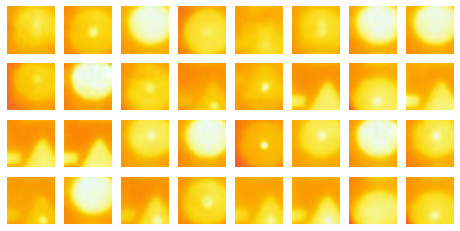

Epoch 122/1000


2053it [02:19, 14.73it/s]


Epoch 123/1000


2053it [02:19, 14.71it/s]


Epoch 124/1000


2053it [02:18, 14.80it/s]


Epoch 125/1000


2053it [02:20, 14.57it/s]


Epoch 126/1000


2053it [02:20, 14.57it/s]


Epoch 127/1000


2053it [02:17, 14.91it/s]


Epoch 128/1000


2053it [02:18, 14.79it/s]


Epoch 129/1000


2053it [02:18, 14.81it/s]


Epoch 130/1000


2053it [02:19, 14.68it/s]


Epoch 131/1000


2053it [02:19, 14.71it/s]


Epoch 132/1000


2053it [02:19, 14.68it/s]


Epoch 133/1000


2053it [02:19, 14.76it/s]


Epoch 134/1000


2053it [02:20, 14.65it/s]


Epoch 135/1000


2053it [02:18, 14.80it/s]


Epoch 136/1000


2053it [02:21, 14.55it/s]


Epoch 137/1000


2053it [02:20, 14.64it/s]


Epoch 138/1000


2053it [02:19, 14.71it/s]


Epoch 139/1000


2053it [02:19, 14.75it/s]


Epoch 140/1000


2053it [02:20, 14.65it/s]


Epoch 141/1000


2053it [02:21, 14.49it/s]


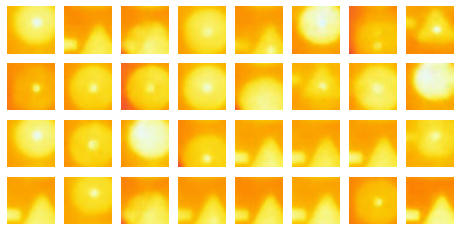

Epoch 142/1000


2053it [02:20, 14.56it/s]


Epoch 143/1000


2053it [02:21, 14.50it/s]


Epoch 144/1000


2053it [02:21, 14.53it/s]


Epoch 145/1000


2053it [02:20, 14.57it/s]


Epoch 146/1000


2053it [02:21, 14.54it/s]


Epoch 147/1000


2053it [02:21, 14.56it/s]


Epoch 148/1000


2053it [02:23, 14.28it/s]


Epoch 149/1000


2053it [02:22, 14.39it/s]


Epoch 150/1000


2053it [02:21, 14.50it/s]


Epoch 151/1000


2053it [02:20, 14.60it/s]


Epoch 152/1000


2053it [02:20, 14.64it/s]


Epoch 153/1000


2053it [02:19, 14.75it/s]


Epoch 154/1000


2053it [02:20, 14.62it/s]


Epoch 155/1000


2053it [02:20, 14.60it/s]


Epoch 156/1000


2053it [02:20, 14.61it/s]


Epoch 157/1000


2053it [02:20, 14.59it/s]


Epoch 158/1000


2053it [02:19, 14.68it/s]


Epoch 159/1000


2053it [02:19, 14.77it/s]


Epoch 160/1000


2053it [02:18, 14.78it/s]


Epoch 161/1000


2053it [02:19, 14.72it/s]


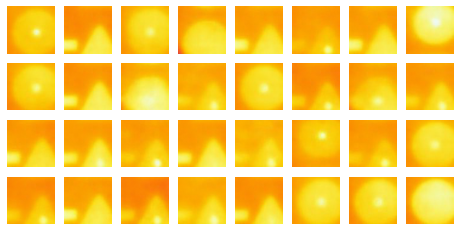

Epoch 162/1000


2053it [02:19, 14.68it/s]


Epoch 163/1000


2053it [02:19, 14.68it/s]


Epoch 164/1000


2053it [02:19, 14.72it/s]


Epoch 165/1000


2053it [02:19, 14.70it/s]


Epoch 166/1000


2053it [02:19, 14.73it/s]


Epoch 167/1000


2053it [02:19, 14.68it/s]


Epoch 168/1000


2053it [02:18, 14.79it/s]


Epoch 169/1000


2053it [02:19, 14.75it/s]


Epoch 170/1000


2053it [02:18, 14.78it/s]


Epoch 171/1000


2053it [02:18, 14.78it/s]


Epoch 172/1000


2053it [02:20, 14.65it/s]


Epoch 173/1000


2053it [02:20, 14.64it/s]


Epoch 174/1000


2053it [02:20, 14.66it/s]


Epoch 175/1000


2053it [02:18, 14.86it/s]


Epoch 176/1000


2053it [02:19, 14.68it/s]


Epoch 177/1000


2053it [02:18, 14.77it/s]


Epoch 178/1000


2053it [02:19, 14.70it/s]


Epoch 179/1000


2053it [02:19, 14.69it/s]


Epoch 180/1000


2053it [02:19, 14.67it/s]


Epoch 181/1000


2053it [02:19, 14.77it/s]


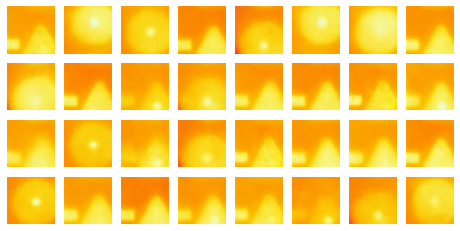

Epoch 182/1000


2053it [02:17, 14.90it/s]


Epoch 183/1000


2053it [02:20, 14.65it/s]


Epoch 184/1000


2053it [02:18, 14.81it/s]


Epoch 185/1000


2053it [02:19, 14.73it/s]


Epoch 186/1000


2053it [02:18, 14.79it/s]


Epoch 187/1000


2053it [02:18, 14.81it/s]


Epoch 188/1000


2053it [02:19, 14.68it/s]


Epoch 189/1000


2053it [02:19, 14.75it/s]


Epoch 190/1000


2053it [02:19, 14.68it/s]


Epoch 191/1000


2053it [02:20, 14.62it/s]


Epoch 192/1000


2053it [02:17, 14.90it/s]


Epoch 193/1000


2053it [02:18, 14.80it/s]


Epoch 194/1000


2053it [02:19, 14.67it/s]


Epoch 195/1000


2053it [02:20, 14.66it/s]


Epoch 196/1000


2053it [02:20, 14.65it/s]


Epoch 197/1000


2053it [02:21, 14.46it/s]


Epoch 198/1000


2053it [02:21, 14.50it/s]


Epoch 199/1000


2053it [02:22, 14.46it/s]


Epoch 200/1000


2053it [02:23, 14.31it/s]


Epoch 201/1000


2053it [02:20, 14.59it/s]


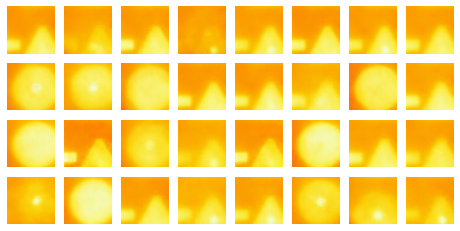

Epoch 202/1000


2053it [02:20, 14.58it/s]


Epoch 203/1000


2053it [02:20, 14.60it/s]


Epoch 204/1000


2053it [02:20, 14.65it/s]


Epoch 205/1000


2053it [02:20, 14.61it/s]


Epoch 206/1000


2053it [02:20, 14.64it/s]


Epoch 207/1000


2053it [02:20, 14.57it/s]


Epoch 208/1000


2053it [02:20, 14.62it/s]


Epoch 209/1000


2053it [02:21, 14.54it/s]


Epoch 210/1000


2053it [02:21, 14.49it/s]


Epoch 211/1000


2053it [02:20, 14.56it/s]


Epoch 212/1000


2053it [02:20, 14.63it/s]


Epoch 213/1000


2053it [02:20, 14.59it/s]


Epoch 214/1000


2053it [02:21, 14.48it/s]


Epoch 215/1000


2053it [02:21, 14.49it/s]


Epoch 216/1000


2053it [02:21, 14.50it/s]


Epoch 217/1000


2053it [02:21, 14.50it/s]


Epoch 218/1000


2053it [02:20, 14.57it/s]


Epoch 219/1000


2053it [02:20, 14.59it/s]


Epoch 220/1000


2053it [02:21, 14.54it/s]


Epoch 221/1000


2053it [02:21, 14.46it/s]


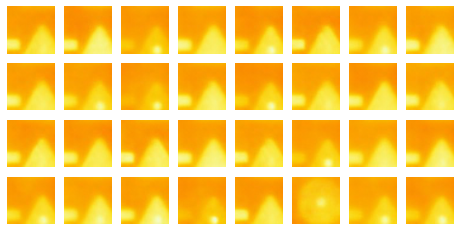

Epoch 222/1000


2053it [02:21, 14.53it/s]


Epoch 223/1000


2053it [02:21, 14.46it/s]


Epoch 224/1000


2053it [02:21, 14.50it/s]


Epoch 225/1000


2053it [02:21, 14.47it/s]


Epoch 226/1000


2053it [02:21, 14.46it/s]


Epoch 227/1000


2053it [02:21, 14.46it/s]


Epoch 228/1000


2053it [02:21, 14.46it/s]


Epoch 229/1000


2053it [02:20, 14.57it/s]


Epoch 230/1000


2053it [02:20, 14.56it/s]


Epoch 231/1000


2053it [02:21, 14.52it/s]


Epoch 232/1000


2053it [02:21, 14.51it/s]


Epoch 233/1000


2053it [02:21, 14.55it/s]


Epoch 234/1000


2053it [02:21, 14.46it/s]


Epoch 235/1000


2053it [02:20, 14.64it/s]


Epoch 236/1000


2053it [02:23, 14.32it/s]


Epoch 237/1000


2053it [02:21, 14.52it/s]


Epoch 238/1000


2053it [02:21, 14.51it/s]


Epoch 239/1000


2053it [02:21, 14.54it/s]


Epoch 240/1000


2053it [02:22, 14.43it/s]


Epoch 241/1000


2053it [02:22, 14.41it/s]


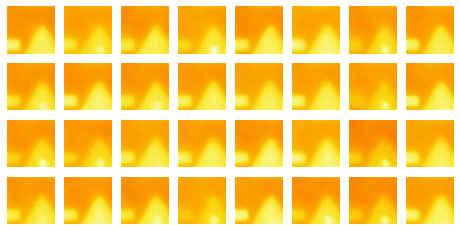

Epoch 242/1000


2053it [02:22, 14.43it/s]


Epoch 243/1000


2053it [02:18, 14.80it/s]


Epoch 244/1000


2053it [02:17, 14.91it/s]


Epoch 245/1000


2053it [02:18, 14.83it/s]


Epoch 246/1000


2053it [02:18, 14.77it/s]


Epoch 247/1000


2053it [02:19, 14.71it/s]


Epoch 248/1000


2053it [02:18, 14.77it/s]


Epoch 249/1000


2053it [02:20, 14.65it/s]


Epoch 250/1000


2053it [02:18, 14.80it/s]


Epoch 251/1000


2053it [02:20, 14.65it/s]


Epoch 252/1000


2053it [02:20, 14.66it/s]


Epoch 253/1000


2053it [02:18, 14.83it/s]


Epoch 254/1000


2053it [02:18, 14.79it/s]


Epoch 255/1000


2053it [02:18, 14.83it/s]


Epoch 256/1000


2053it [02:20, 14.64it/s]


Epoch 257/1000


2053it [02:18, 14.85it/s]


Epoch 258/1000


2053it [02:19, 14.73it/s]


Epoch 259/1000


2053it [02:18, 14.83it/s]


Epoch 260/1000


2053it [02:18, 14.77it/s]


Epoch 261/1000


2053it [02:18, 14.83it/s]


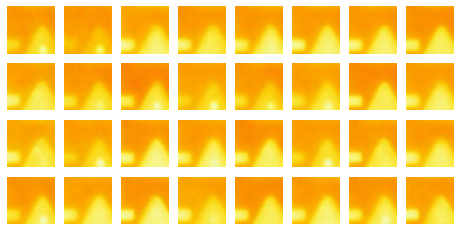

Epoch 262/1000


2053it [02:18, 14.80it/s]


Epoch 263/1000


2053it [02:19, 14.74it/s]


Epoch 264/1000


2053it [02:18, 14.81it/s]


Epoch 265/1000


2053it [02:18, 14.79it/s]


Epoch 266/1000


2053it [02:18, 14.86it/s]


Epoch 267/1000


2053it [02:19, 14.74it/s]


Epoch 268/1000


2053it [02:19, 14.73it/s]


Epoch 269/1000


2053it [02:19, 14.75it/s]


Epoch 270/1000


2053it [02:20, 14.66it/s]


Epoch 271/1000


2053it [02:17, 14.90it/s]


Epoch 272/1000


2053it [02:18, 14.79it/s]


Epoch 273/1000


2053it [02:18, 14.82it/s]


Epoch 274/1000


2053it [02:18, 14.78it/s]


Epoch 275/1000


2053it [02:18, 14.82it/s]


Epoch 276/1000


2053it [02:19, 14.68it/s]


Epoch 277/1000


2053it [02:19, 14.72it/s]


Epoch 278/1000


2053it [02:19, 14.72it/s]


Epoch 279/1000


2053it [02:18, 14.85it/s]


Epoch 280/1000


2053it [02:17, 14.88it/s]


Epoch 281/1000


2053it [02:18, 14.85it/s]


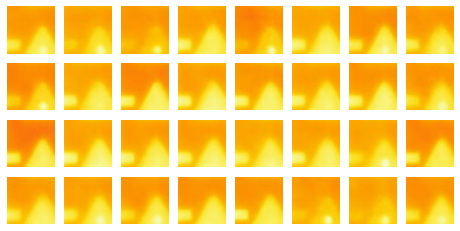

Epoch 282/1000


2053it [02:18, 14.77it/s]


Epoch 283/1000


2053it [02:19, 14.72it/s]


Epoch 284/1000


2053it [02:17, 14.88it/s]


Epoch 285/1000


2053it [02:18, 14.87it/s]


Epoch 286/1000


2053it [02:21, 14.46it/s]


Epoch 287/1000


2053it [02:20, 14.64it/s]


Epoch 288/1000


2053it [02:20, 14.61it/s]


Epoch 289/1000


2053it [02:20, 14.66it/s]


Epoch 290/1000


2053it [02:19, 14.76it/s]


Epoch 291/1000


2053it [02:18, 14.81it/s]


Epoch 292/1000


2053it [02:20, 14.65it/s]


Epoch 293/1000


2053it [02:18, 14.83it/s]


Epoch 294/1000


2053it [02:19, 14.75it/s]


Epoch 295/1000


2053it [02:21, 14.55it/s]


Epoch 296/1000


2053it [02:19, 14.67it/s]


Epoch 297/1000


2053it [02:21, 14.49it/s]


Epoch 298/1000


2053it [02:19, 14.71it/s]


Epoch 299/1000


2053it [02:21, 14.48it/s]


Epoch 300/1000


2053it [02:22, 14.36it/s]


Epoch 301/1000


2053it [02:22, 14.40it/s]


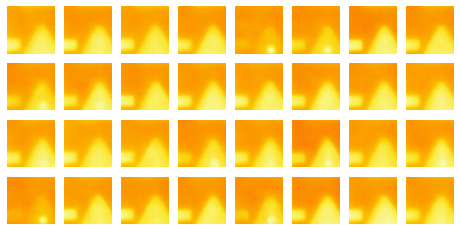

Epoch 302/1000


2053it [02:22, 14.43it/s]


Epoch 303/1000


2053it [02:22, 14.37it/s]


Epoch 304/1000


2053it [02:21, 14.53it/s]


Epoch 305/1000


2053it [02:22, 14.44it/s]


Epoch 306/1000


2053it [02:20, 14.57it/s]


Epoch 307/1000


2053it [02:21, 14.47it/s]


Epoch 308/1000


2053it [02:22, 14.36it/s]


Epoch 309/1000


2053it [02:21, 14.49it/s]


Epoch 310/1000


2053it [02:21, 14.48it/s]


Epoch 311/1000


2053it [02:22, 14.45it/s]


Epoch 312/1000


2053it [02:22, 14.40it/s]


Epoch 313/1000


2053it [02:22, 14.39it/s]


Epoch 314/1000


2053it [02:24, 14.17it/s]


Epoch 315/1000


2053it [02:22, 14.40it/s]


Epoch 316/1000


2053it [02:22, 14.42it/s]


Epoch 317/1000


2053it [02:21, 14.53it/s]


Epoch 318/1000


2053it [02:23, 14.31it/s]


Epoch 319/1000


2053it [02:21, 14.47it/s]


Epoch 320/1000


2053it [02:22, 14.39it/s]


Epoch 321/1000


2053it [02:22, 14.37it/s]


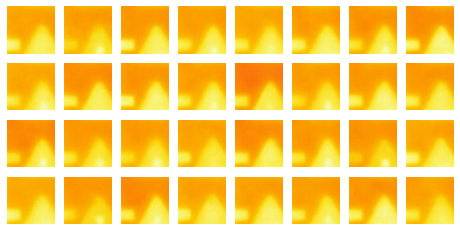

Epoch 322/1000


2053it [02:23, 14.35it/s]


Epoch 323/1000


2053it [02:22, 14.36it/s]


Epoch 324/1000


2053it [02:22, 14.39it/s]


Epoch 325/1000


2053it [02:22, 14.43it/s]


Epoch 326/1000


2053it [02:23, 14.27it/s]


Epoch 327/1000


2053it [02:23, 14.27it/s]


Epoch 328/1000


2053it [02:22, 14.43it/s]


Epoch 329/1000


2053it [02:22, 14.43it/s]


Epoch 330/1000


2053it [02:21, 14.46it/s]


Epoch 331/1000


2053it [02:22, 14.41it/s]


Epoch 332/1000


2053it [02:22, 14.45it/s]


Epoch 333/1000


2053it [02:21, 14.46it/s]


Epoch 334/1000


2053it [02:21, 14.49it/s]


Epoch 335/1000


2053it [02:22, 14.42it/s]


Epoch 336/1000


2053it [02:21, 14.50it/s]


Epoch 337/1000


2053it [02:21, 14.46it/s]


Epoch 338/1000


2053it [02:20, 14.61it/s]


Epoch 339/1000


2053it [02:20, 14.65it/s]


Epoch 340/1000


2053it [02:20, 14.63it/s]


Epoch 341/1000


2053it [02:19, 14.69it/s]


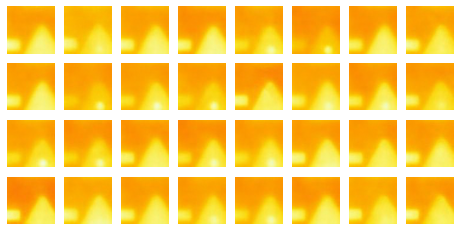

Epoch 342/1000


2053it [02:20, 14.59it/s]


Epoch 343/1000


2053it [02:20, 14.60it/s]


Epoch 344/1000


2053it [02:21, 14.51it/s]


Epoch 345/1000


2053it [02:20, 14.58it/s]


Epoch 346/1000


2053it [02:21, 14.53it/s]


Epoch 347/1000


2053it [02:20, 14.61it/s]


Epoch 348/1000


2053it [02:20, 14.65it/s]


Epoch 349/1000


2053it [02:20, 14.61it/s]


Epoch 350/1000


2053it [02:19, 14.71it/s]


Epoch 351/1000


2053it [02:20, 14.64it/s]


Epoch 352/1000


2053it [02:19, 14.68it/s]


Epoch 353/1000


2053it [02:20, 14.65it/s]


Epoch 354/1000


2053it [02:18, 14.77it/s]


Epoch 355/1000


2053it [02:20, 14.66it/s]


Epoch 356/1000


2053it [02:19, 14.69it/s]


Epoch 357/1000


2053it [02:19, 14.69it/s]


Epoch 358/1000


2053it [02:19, 14.71it/s]


Epoch 359/1000


2053it [02:19, 14.73it/s]


Epoch 360/1000


2053it [02:21, 14.48it/s]


Epoch 361/1000


23it [00:02,  8.00it/s]


KeyboardInterrupt: ignored

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)